# The Rise and Fall of the Third Reich
# A History of Nazi Germany 
# by William L. Shirer
## A Textual Analysis

Read in file.

In [3]:
import pandas as pd
import book_reader as br
import book_viz as bv
import numpy as np
import json
import os
from IPython.display import display
rafo3r_text = open('rafo3r.txt', 'r', encoding='utf-8').read()
generate_book_df = False
generate_toc_df = False
generate_pivots = False
rafo3r_reader = br.book_reader('rafo3r', generate_book_df, generate_toc_df, generate_pivots)
book_file = 'rafo3r.txt'
h5_file = 'rafo3r.h5'
rafo3r, toc, book_pivot1, book_pivot2 = rafo3r_reader.main(book_file, h5_file)

Starting
Book processed
TOC processed
Chapter Markers made
Pivots processed


In [3]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
py.sign_in('yg2bsm', '8e3m3cer5e')

In [ ]:
rafo3r_sliced = pd.DataFrame()
for word in set(list(rafo3r[rafo3r['Stop Word'] == False]['Word'])): #iterate over unique words
    for i, v in enumerate(broken_list):   
    #if i % break_point == 0 or x == len(rafo3r):
        if i == 0:
            v0 = 0
        else:
            v0 = broken_list[i-1]
        rafo3r_sliced.loc[str(i),word] = rafo3r[rafo3r['Word'] == word][v0:v]['Running Count'].sum
display (rafo3r_sliced.head())

<IPython.core.display.Javascript object>


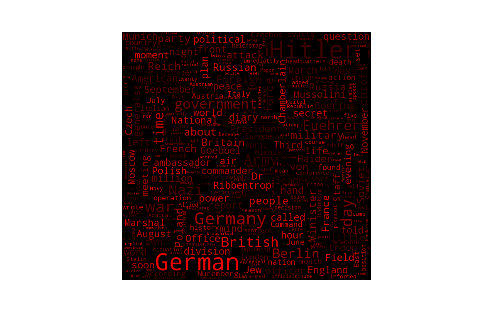

In [26]:
%matplotlib notebook
from wordcloud import WordCloud, get_single_color_func
import matplotlib.pyplot as plt

rafo3r_wordcloud = WordCloud(width = 600, height = 600, max_font_size = 60,
                             min_font_size = 8,relative_scaling = .5, scale = 1, max_words = 400, 
                             color_func = get_single_color_func('darkred'),
                             stopwords = rafo3r_reader.stopwords).generate(rafo3r_text)

#rafo3r_wordcloud = WordCloud(min_font_size = 8, max_font_size = 70, relative_scaling = .5, 
#                             width = 600, height = 600, scale = 1, max_words = 400, 
#                             color_func = get_single_color_func('darkred'),random_state=42,
#                             ,).generate(rafo3r_text)
#regexp = rafo3r_reader.re_splitter
plt.figure()
plt.imshow(rafo3r_wordcloud)
plt.axis("off")
plt.show()

In [466]:
def word_vs_range_df_maker(book_df, word_json, break_point = 10000, min_count_req = 400):
    peak = len(book_df)
    broken_list = list(range(0,peak,break_point))
    broken_list.pop(0)#remove 0
    if broken_list[-1] != peak: broken_list.append(peak)
    plotter_df = pd.DataFrame()
    for word_main in word_json:
        these_words = word_json[word_main]
        for i, v in enumerate(broken_list):
            if i == 0:
                v0 = 0
            else:
                v0 = broken_list[i-1]
            plotter_df.loc[str(v),word_main] = _count_within_range(word_main,v0,v)
            for word_sub in these_words:
                plotter_df.loc[str(v),word_main] += _count_within_range(word_sub,v0,v)
    plotter_df = plotter_df.drop(plotter_df.sum(axis=0)
                                 [plotter_df.sum(axis=0)<min_count_req].index,axis=1)
    return plotter_df
#places_json = json.loads('{"germany":["german"],"austria":[]}')
#tester00 = word_vs_range_df_maker(rafo3r, places_json, 10000, 1)
#tester01 = word_vs_range_df_maker(rafo3r, people_json, 10000, 1)

In [352]:
places = open(os.getcwd() + os.sep + 'places.json', 'r').read()
places_json = json.loads(places)
people = open(os.getcwd() + os.sep + 'people.json', 'r').read()
people_json = json.loads(people)

In [3]:
rafo3r_viz = bv.book_viz(rafo3r, toc, p1, p2, places_json, people_json)
rafo3r_viz.places_vs_chapters()

VIZ


In [307]:
#using pivot2, create a new dataframe with words (subset based on places from json) as columns and chapter (counts)
#as rows.
def word_vs_chapter_df_maker(book_pivot2, word_json, ch_list, min_count_req = 400):
    bp2 = book_pivot2.copy()  #to my suprise, without this i was modifying the actual df (didnt think would happen in func)
    
    #######                      
    #remove this once you fix bug in pivot maker
    #print('P1',bp2.head())
    bp2.index = bp2.index.droplevel(1)
    bp2 = bp2[~bp2.index.duplicated(keep='first')]
    #print('P2',bp2.head())
    #######                      
    
    plotter_df = pd.DataFrame()
    for word_main in word_json:
        other_words = word_json[word_main]
        s = 'Word == "%s"'%(word_main)
        master_df = bp2.query(s).reset_index().set_index('Chapter')
        master_df = master_df.reindex(ch_list).fillna(0)
        master_df['Word'] = word_main
        master_df.sort_index(inplace=True)
        try:
            del master_df['Book']
        except:
            #remove this try once you fix the issue that lets you remove the stuff at start.
            #issue is that you remove book up there so you cant delete it here.
            pass
        for word_sub in other_words:
            s = 'Word == "%s"'%(word_sub)
            minor_df = bp2.query(s).reset_index().set_index('Chapter')
            minor_df = minor_df.reindex(ch_list).fillna(0)
            minor_df.sort_index(inplace=True)
            try:
                del minor_df['Book']
            except:
                #remove this try once you fix the issue that lets you remove the stuff at start.
                #issue is that you remove book up there so you cant delete it here.
                pass
            master_df['Count'] = master_df['Count'] + minor_df['Count']
        plotter_df = pd.concat([plotter_df,master_df])
    plotter_df = plotter_df.reset_index()
    plotter_df.set_index(['Chapter', 'Word'], inplace=True)
    plotter_df = plotter_df.unstack(level=1) 
    plotter_df = plotter_df.drop(plotter_df.sum(axis=0)
                                 [plotter_df.sum(axis=0)<min_count_req].index,axis=1)
    plotter_df.columns = plotter_df.columns.droplevel(0)
    return plotter_df

In [311]:
num_chapters = max(book_pivot2.reset_index()['Chapter'])
ch_list = list(range(1,num_chapters+1))

In [468]:
places_vs_chapter_df = word_vs_chapter_df_maker(book_pivot2, places_json, ch_list, 400)
people_vs_chapter_df = word_vs_chapter_df_maker(book_pivot2, people_json, ch_list, 100)
places_vs_range_df = word_vs_range_df_maker(rafo3r, places_json, 10000, 300)
people_vs_range_df = word_vs_range_df_maker(rafo3r, people_json, 10000, 100)

/Users/lukestarnes/anaconda/envs/Py3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Users/lukestarnes/anaconda/envs/Py3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [483]:
#why does chapters total for poland to 1047.0, but range totals to 957.0
#print(_count_within_range(word, v0, v))
print (toc[-2:])
print (len(rafo3r))
print (rafo3r.query('Chapter == 33'))
#bug: words marked ch. 1 go from pos 0 to 2490, but 2490 is *start* of Ch. 1...
#and there are 33 chapter.  last 2...
#Ch32         A BRIEF EPILOGUE      1023    570995
#Ch33                AFTERWORD      1027    572270
#but words marked ch 33 runs from 570996 to 572270... 
#length of book is 573408

                Section Title  Page Num  Location
Section Num                                      
Ch32         A BRIEF EPILOGUE      1023    570995
Ch33                AFTERWORD      1027    572270
573408
             Word Stop Word  Count  Running Count  Position  Book  Chapter
570996         32     False      6              6    570996     7       33
570997          a      True      0              0    570997     7       33
570998      brief     False     46             44    570998     7       33
570999   epilogue     False      3              2    570999     7       33
571000          i      True      0              0    571000     7       33
571001       went      True      0              0    571001     7       33
571002       back      True      0              0    571002     7       33
571003       that      True      0              0    571003     7       33
571004     autumn     False     47             47    571004     7       33
571005         to      True      0         

In [471]:
print(places_vs_chapter_df.sum(axis=0).sort_values()[-5:])
print(places_vs_range_df.sum(axis=0).sort_values()[-5:])
print(people_vs_chapter_df.sum(axis=0).sort_values()[-5:])
print(people_vs_range_df.sum(axis=0).sort_values()[-5:])
#why are counts not the same between chapter split and 10k split?

Word
poland     1047.0
france     1193.0
russia     2028.0
britain    2304.0
germany    6825.0
dtype: float64
poland      957.0
france     1052.0
russia     1822.0
britain    2093.0
germany    6494.0
dtype: float64
Word
chamberlain     334.0
ribbentrop      463.0
goering         486.0
mussolini       526.0
hitler         5309.0
dtype: float64
chamberlain     304.0
ribbentrop      424.0
goering         432.0
mussolini       453.0
hitler         5195.0
dtype: float64


In [437]:
def _col_clean(name):
    return name.replace('_',' ').title()

In [438]:
c = 256 / len(places_vs_chapter_df.columns)
new_col_names = list(map(_col_clean, list(places_vs_chapter_df.columns)))

py.iplot(dict(data=[{
    'x': places_vs_chapter_df.index,
    'y': places_vs_chapter_df[col],
    'name': new_col_names[i],
    'fill' : 'tonexty',
    'line' : dict(color = ('rgb(%i, %i, 100)'%(int(c * i),int(255 - c * i)))),
}  for i, col in enumerate(places_vs_chapter_df.columns)], layout=dict(
            title = 'RaFo3R Places vs Chapter',
            dragmode = 'zoom',
            xaxis = dict(title = 'Chapter', tickvals = list(range(2,36,2)), tickmode = 'array', 
                         rangeslider = dict(thickness=0.2)),
            yaxis = dict(title = 'Word Count'))), filename='plotly/places_vs_chapter')

In [470]:
c = 256 / len(people_vs_chapter_df.columns)
new_col_names = list(map(_col_clean, list(people_vs_chapter_df.columns)))

py.iplot(dict(data=[{
    'x': people_vs_chapter_df.index,
    'y': people_vs_chapter_df[col],
    'name': new_col_names[i],
    'fill' : 'tonexty',
    'line' : dict(color = ('rgb(%i, %i, 100)'%(int(c * i),int(255 - c * i)))),
}  for i, col in enumerate(people_vs_chapter_df.columns)], layout=dict(
            title = 'RaFo3R People vs Chapter',
            dragmode = 'zoom',
            xaxis = dict(title = 'Chapter', tickvals = list(range(2,36,2)), tickmode = 'array', 
                         rangeslider = dict(thickness=0.2)),
            yaxis = dict(title = 'Word Count'))), filename='plotly/people_vs_chapter')

In [464]:
c = 256 / len(places_vs_range_df.columns)
new_col_names = list(map(_col_clean, list(places_vs_range_df.columns)))
x.insert(0,'0')

py.iplot(dict(data=[{
    'x': list(places_vs_range_df.index).insert(0,'0'),
    'y': places_vs_range_df[col],
    'name': new_col_names[i],
    'fill' : 'tonexty',
    'line' : dict(color = ('rgb(%i, %i, 100)'%(int(c * i),int(255 - c * i)))),
}  for i, col in enumerate(places_vs_range_df.columns)], layout=dict(
            title = 'RaFo3R Places vs 10k Words',
            xaxis = dict(title = 'Per 10k Words', rangeslider = dict(thickness=0.20)),
            yaxis = dict(title = 'Word Count'))), filename='plotly/places_vs_range')

In [445]:
c = 256 / len(people_vs_range_df.columns)
new_col_names = list(map(_col_clean, list(people_vs_range_df.columns)))

py.iplot(dict(data=[{
    'x': people_vs_range_df.index,
    'y': people_vs_range_df[col],
    'name': new_col_names[i],
    'fill' : 'tonexty',
    'line' : dict(color = ('rgb(%i, %i, 100)'%(int(c * i),int(255 - c * i)))),
}  for i, col in enumerate(people_vs_range_df.columns)], layout=dict(
            title = 'RaFo3R People vs 10k Words',
            #dragmode = 'zoom',
            xaxis = dict(title = 'Per 10k Words', rangeslider = dict(thickness=0.20)),
            yaxis = dict(title = 'Word Count'))), filename='plotly/people_vs_range')

In [ ]:
#table - top 5 people by chapter

In [413]:
#display(people_vs_chapter_df.head())
new = []

for i in range(1,33):
    new.append(list(people_vs_chapter_df.loc[i].sort_values(ascending=False)[:7].index))
my_df=pd.DataFrame(new,index=list(range(1,33)),columns=list(range(1,8)))
table = FF.create_table(my_df,index=True)
py.iplot(table, filename='pandas_table')

In [ ]:
#%matplotlib inline
germany = rafo3r[rafo3r['Word'] == 'germany']
#c,bins = np.histogram(germany)
#germany.hist(bins=bins)



df.iplot(kind='scatter', filename='cufflinks/cf-simple-line')
data = [go.Scatter(x= germany.index,y=germany['Running Count'],name='Germany')]
#data2 = [go.Histogram(x= c,#germany['Running Occurance'],
#                      name='Germany')]
layout = go.Layout(title='scatter plot with pandas',
                   yaxis=dict(title='random distribution'), 
                   xaxis=dict(title='linspace'))
py.iplot(data, filename='pandas/basic-line-plot')#'basic-histogram'

In [90]:
#data = [go.Scatter(x= plotter_df.index,y=plotter_df['Count'],name='All')]
#data2 = [go.Histogram(x= c,#germany['Running Occurance'],
#                      name='Germany')]
layout = go.Layout(title='scatter plot with pandas',
                   yaxis=dict(title='random distribution'), 
                   xaxis=dict(title='linspace'))
#py.iplot(data, filename='pandas/basic-line-plot')#'basic-histogram'

In [312]:
grouped = rafo3r.groupby('Word')
grouped.describe()
#display(rafo3r.head())

Count       Position  Running Count
Word                                                 
           count   52.0      52.000000      52.000000
           mean     0.0  188255.538462       0.000000
           std      0.0  142844.055449       0.000000
           min      0.0     263.000000       0.000000
           25%      0.0   67038.500000       0.000000
           50%      0.0  170194.000000       0.000000
           75%      0.0  284169.500000       0.000000
           max      0.0  494003.000000       0.000000
$1         count    3.0       3.000000       3.000000
           mean     0.0  277315.333333       0.000000
           std      0.0  174176.980251       0.000000
           min      0.0  138672.000000       0.000000
           25%      0.0  179565.000000       0.000000
           50%      0.0  220458.000000       0.000000
           75%      0.0  346637.000000       0.000000
           max      0.0  472816.000000       0.000000
$10        count    1.0       1.000000       1.000000
           mean     0.0  475960.000000       0.000000
           std      NaN            NaN            NaN
           min      0.0  475960.000000       0.000000
           25%      0.0  475960.000000       0.000000
           50%      0.0  475960.000000       0.000000
           75%      0.0  475960.000000       0.000000
           max      0.0  475960.000000       0.000000
$100       count    1.0       1.000000       1.000000
           mean     0.0  507017.000000       0.000000
           std      NaN            NaN            NaN
           min      0.0  507017.000000       0.000000
           25%      0.0  507017.000000       0.000000
           50%      0.0  507017.000000       0.000000
...                 ...            ...            ...
‡ohlendorf std      NaN            NaN            NaN
           min      1.0  480630.000000       1.000000
           25%      1.0  480630.000000       1.000000
           50%      1.0  480630.000000       1.000000
           75%      1.0  480630.000000       1.000000
           max      1.0  480630.000000       1.000000
‡see       count    1.0       1.000000       1.000000
           mean     1.0  482917.000000       1.000000
           std      NaN            NaN            NaN
           min      1.0  482917.000000       1.000000
           25%      1.0  482917.000000       1.000000
           50%      1.0  482917.000000       1.000000
           75%      1.0  482917.000000       1.000000
           max      1.0  482917.000000       1.000000
‡the       count    2.0       2.000000       2.000000
           mean     2.0  370780.000000       1.500000
           std      0.0   97446.385515       0.707107
           min      2.0  301875.000000       1.000000
           25%      2.0  336327.500000       1.250000
           50%      2.0  370780.000000       1.500000
           75%      2.0  405232.500000       1.750000
           max      2.0  439685.000000       2.000000
‡this      count    1.0       1.000000       1.000000
           mean     1.0  222970.000000       1.000000
           std      NaN            NaN            NaN
           min      1.0  222970.000000       1.000000
           25%      1.0  222970.000000       1.000000
           50%      1.0  222970.000000       1.000000
           75%      1.0  222970.000000       1.000000
           max      1.0  222970.000000       1.000000

[180744 rows x 3 columns]

In [313]:
rafo3r['Count'].sort_values()[-10:] # top 10 values

568477    4222
136095    4222
399802    4222
502264    4222
321664    4222
103615    4222
253602    4222
11536     4222
51862     4222
27601     4222
Name: Count, dtype: int64

In [ ]:
rafo3r['Position'] = rafo3r.index

occurances = rafo3r.groupby('Word').size()
mega_words = occurances.index[occurances >= 1000]
rafo3r.index = rafo3r['Word']
#sw = rafo3r.ix['Stop Word']
#sw.head()

In [ ]:
def start_loc(x):
    return int(100 * min(x) / len(rafo3r))
def end_loc(x):
    return int(100 * max(x) / len(rafo3r))
rafo3r_pt = rafo3r[rafo3r['Stop Word'] == False].pivot_table(values='Position', 
            aggfunc=[len,start_loc,end_loc], index='Words')
rafo3r_pt.sort_values('len',ascending=False,inplace=True)
rafo3r_pt.rename(columns={'len': 'Count'}, inplace=True)
display(rafo3r_pt[:10])

rafo3r_pt2 = rafo3r[rafo3r['Stop Word'] == False].pivot_table(values='Position', 
             aggfunc=[len], index=['Word','Book','Chapter'])
rafo3r_pt2.sort_values('len',ascending=False,inplace=True)

display(rafo3r_pt2[:10])